# Preliminary setup and data exploration

In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# Defining the random seeds is especially important
random.seed(100)
np.random.seed(100)

In [3]:
# Import agents from src
from src.agents import *

In [4]:
#data = pd.read_csv('data/10000dataset.csv') # easy
#data = pd.read_csv('data/movielens_10_arms.csv') # easy
#data = pd.read_csv('data/yahoo_reduced_arms.csv') # harder
data = pd.read_csv('data/movielens_202_arms.csv') # lots of arms

# Reshuffle data
data = data.sample(frac=1, random_state=100)

In [5]:
# Number of arms
n_arms = data['selected_arm'].max() + 1
n_arms = int(n_arms)
n_arms

202

In [6]:
data.sample(n=5, random_state=100)

,t,userId,movieId,rating,timestamp,movieId_movie,title,(no genres listed),Action,Adventure,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,t.1,liked,selected_arm,reward
2748845,2748845,13438,904,5.0,1014942829,925.0,Golden Earrings (1947),False,False,True,...,False,True,False,False,True,False,2748845,1,68.0,1
2633235,2633235,8810,6,3.0,1167146489,7.0,Sabrina (1995),False,False,False,...,False,True,False,False,False,False,2633235,0,2.0,0
495101,495101,65378,587,4.0,1299102985,595.0,Beauty and the Beast (1991),False,False,False,...,False,True,False,False,False,False,495101,0,52.0,0
1504940,1504940,148389,733,4.0,843508815,749.0,"Man from Down Under, The (1943)",False,False,False,...,False,False,False,False,False,False,1504940,0,62.0,0
1535800,1535800,107344,2916,4.0,1502310015,3008.0,Last Night (1998),False,False,False,...,False,False,True,False,False,False,1535800,0,141.0,0


In [7]:
data.shape

(4051716, 31)

Its important to check the arms have been chosen uniformly randomly:

In [8]:
data['selected_arm'].describe()

count    4.051716e+06
mean     1.005000e+02
std      5.831167e+01
min      0.000000e+00
25%      5.000000e+01
50%      1.005000e+02
75%      1.510000e+02
max      2.010000e+02
Name: selected_arm, dtype: float64

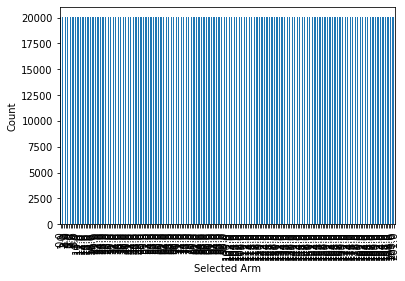

In [9]:
data['selected_arm'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Selected Arm')
plt.ylabel('Count')
plt.show()

The reward is a Bernoulli distribution:

In [10]:
data['reward'].describe()

count    4.051716e+06
mean     3.100277e-01
std      4.625047e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: reward, dtype: float64

The reward expectancy depends on the arm chosen:

Text(0.5, 0, 'Selected Arm')

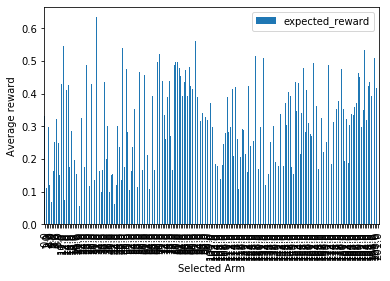

In [11]:
expected_reward = data.groupby('selected_arm').agg({'reward':'mean'}).rename({'reward':'expected_reward'},axis=1)
expected_reward.plot(kind='bar')
plt.ylabel('Average reward')
plt.xlabel('Selected Arm')

In [12]:
data.groupby('selected_arm').agg({'reward':'mean'}).sort_values('reward', ascending=False)

,reward
selected_arm,
31.0,0.634360
67.0,0.607089
169.0,0.567355
91.0,0.562569
143.0,0.558281
...,...
12.0,0.073287
4.0,0.069199
42.0,0.061771


All 136 features are bernoulli

# Creating Environments from the Data (Slot Machines)

This assumes the data has columns:
- `'selected_arm'` ranging from `0` to `(n_arms - 1)` corresponding to the selected arm
- `'reward'` which is the reward of the selected sample (row)

The experiments are sampled randomly from the data where the corresponding arm was chosen.

In [13]:
class Environment_From_Data():
    def __init__(self, data):
        """
        data: pd.DataFrame
            dataframe containing columns 'reward' and 'selected arm'
        """
        self.data = data
        # Save rewards grouped by arms to make the rest of computations go much faster
        self.data_groupby_arms = data.groupby('selected_arm')
    
    def get_reward(self, arm):
        # Chose randomly one index in the data with selected_arm = arm
        index = np.random.choice(self.data_groupby_arms.groups[arm])
        reward = data.loc[index, 'reward']
        return reward

In [14]:
environment = Environment_From_Data(data)

# Random argmax

The $\arg\max$ function is used very often in bandits algorithms. 

It is important to select a random arm in case of a tie.

In [15]:
argmax??

Signature: argmax(vec)
Source:   
def argmax(vec):
    """Chose randomly one index where the input realizes it's maximum."""
    return np.random.choice((vec == vec.max()).nonzero()[0])
File:      ~/Repos/bandits/src/agents.py
Type:      function


# Defining a base Agent other will be based upon

These are the basic properties of a multi-armed bandit.

In [16]:
Agent??

Init signature: Agent(n_arms)
Source:        
class Agent():
    """Base properties of all multi-armed bandits."""
    def __init__(self, n_arms):
        """
        n_arms: int
            Number of arms
        """
        self.n_arms = n_arms
        self.tries = np.zeros(n_arms)
        self.successes = np.zeros(n_arms)
        
    @property
    def _total_tries(self): 
        return self.tries.sum()
    
    def add_observation(self, arm, reward):
        """An observation consists of a pair `(arm, reward)`.
        arm: int
            Chosen arm of the observation
        reward: float
            Reward of the observation
        """
        self.tries[arm] += 1
        self.successes[arm] += reward
    
    def select_arm(self):
        """Placeholder way of selecting an arm."""
        arm = self._total_tries % self.n_arms
        return arm
File:           ~/Repos/bandits/src/agents.py
Type:           type
Subclasses:     GreedyExploreFirst, EpsilonGreedy, UCB1, BayesUCB,

# Experiments

This part will be used to log the results of the different bandit simulations (experiments).

In [17]:
T = n_arms * 200 # Number of steps in the simulations

In [18]:
class Experiment():
    def __init__(self, agent, environment, T, name='No experiment name'):
        self.name = name
        self.agent = agent
        self.environment = environment
        self.cumulative_reward_history = [0]
        for step in range(T):
            self._run_one_step()

    def _run_one_step(self):
        arm = self.agent.select_arm()
        reward = self.environment.get_reward(arm)
        self.agent.add_observation(arm, reward)
        cumulative_reward = self.cumulative_reward_history[-1] + reward
        self.cumulative_reward_history.append(cumulative_reward)

    def plot_cumulative_reward(self):
        plt.plot(self.cumulative_reward_history)
        plt.title('Cumulative Reward', fontsize=13)
        plt.xlabel('Tries')
        plt.ylabel('Cumulative Reward')

In [19]:
def plot_tries_vs_expected_reward(tries, reward):
    """Thanks to https://stackoverflow.com/a/31548279"""
    reward = reward.copy()
    reward['tries'] = tries
    width = .3
    reward['tries'].plot(kind='bar', color='#55A868', position=1, width=width, legend=True, figsize=(12,6))
    reward['expected_reward'].plot(kind='bar', color='#4C72B0', position=0, width=width, legend=True, secondary_y=True)
    plt.title('Total number of tries vs expected reward for each arm')
    plt.grid()
    plt.show()

In [20]:
experiment_history = []

# Implementing a simple 'Explore First then Greedy' strategy

We explore for `learning_stop` steps then exploit the reward that gave the most expected reward so far.

In [21]:
??GreedyExploreFirst

Init signature: GreedyExploreFirst(n_arms, learning_stop)
Source:        
class GreedyExploreFirst(Agent):
    """We explore for `learning_stop` steps then exploit the reward that gave the most expected reward so far."""
    def __init__(self, n_arms, learning_stop):
        """
        n_arms: int
            Number of arms
        learning_stop: int
            Time step until we decide to stop chosing arms randomly
        """
        super().__init__(n_arms)
        self.learning_stop = learning_stop
    
    def select_arm(self):
        # if learning hasn't stopped yet, chose random arm
        if self._total_tries < self.learning_stop:
            arm = self._total_tries % self.n_arms # can also replace with arm = random.randint(0, self.n_arms - 1)
        # else chose arm with most success rate
        else:
            success_rate = self.successes / self.tries
            arm = argmax(success_rate)
        arm = int(arm)
        return arm
File:           ~/Repos/bandits/src/

In [22]:
learning_stop = n_arms * 20 # Setting k tries per arm

agent = GreedyExploreFirst(n_arms=n_arms, learning_stop=learning_stop) # Define Agent
 
experiment = Experiment(agent, environment, T, 'GreedyExploreFirst') # Run Experiment

experiment_history.append(experiment) # Add experiment to history

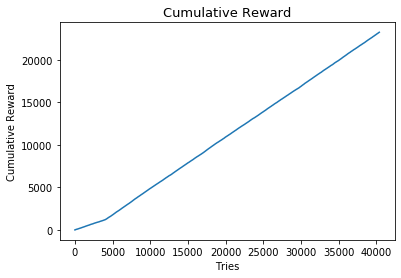

In [23]:
experiment.plot_cumulative_reward()

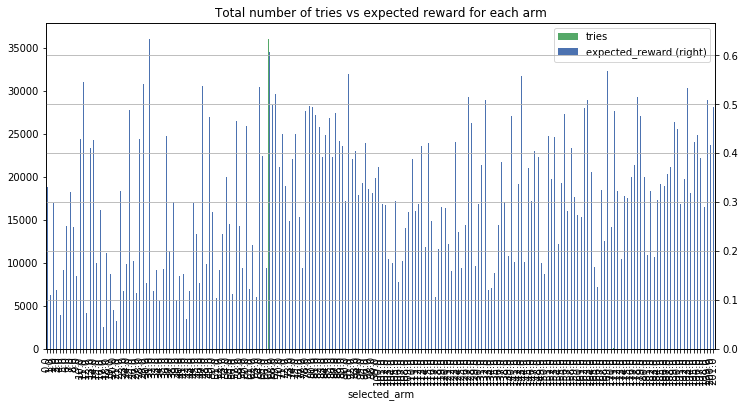

In [24]:
plot_tries_vs_expected_reward(agent.tries, expected_reward)

# Implementing an Epsilon Greedy Strategy

At each step, we throw an $\epsilon$-weighted coin toss do decide wether to explore or exploit.

In [25]:
??EpsilonGreedy

Init signature: EpsilonGreedy(n_arms)
Source:        
class EpsilonGreedy(Agent):
    """At each step, we throw an $\epsilon$-weighted coin toss do decide wether to explore or exploit."""
    @property
    def _epsilon(self):
        # value taken from https://arxiv.org/pdf/1904.07272.pdf theorem 1.6
        epsilon = (self.n_arms * np.log(self._total_tries + 1) / self._total_tries) ** (1/3)
        epsilon = min(epsilon, 1)
        return epsilon
    
    def select_arm(self):
        # if epsilon-weighted coin toss is true, explore
        
        if self._total_tries < self.n_arms:
            arm = self._total_tries
        else:
            epsilon = self._epsilon
            if bernoulli(epsilon).rvs():
                arm = random.randint(0, self.n_arms - 1)
            # else exploit (chose arm with most success rate)
            else:
                success_rate = self.successes / (self.tries + 1e-6)
                arm = argmax(success_rate)
        arm = int(arm)
        r

In [26]:
agent = EpsilonGreedy(n_arms=n_arms)

experiment = Experiment(agent, environment, T, 'EpsilonGreedy')

experiment_history.append(experiment) # Add experiment to history

In [27]:
# plt.plot(epsilon_history)
# plt.title('Epsilon Policy')
# plt.xlabel('Tries')
# plt.ylabel('Epsilon')

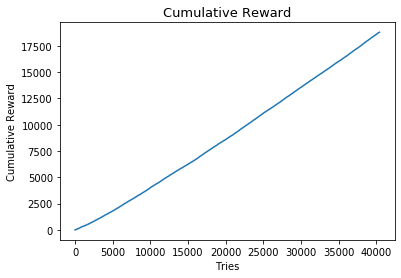

In [28]:
experiment.plot_cumulative_reward()

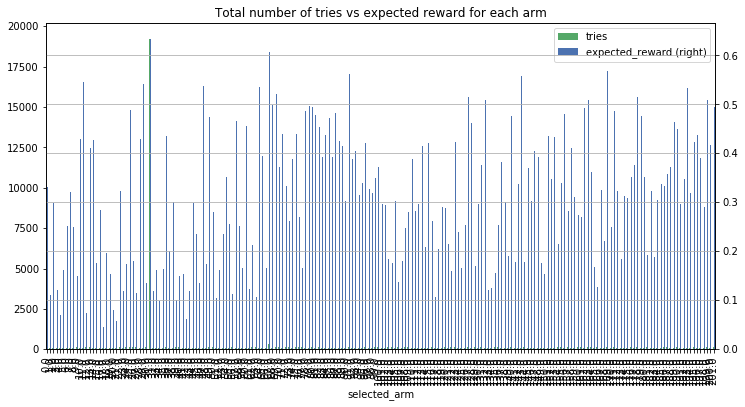

In [29]:
plot_tries_vs_expected_reward(agent.tries, expected_reward)

# UCB1

This uses the concept of 'optimism under uncertainty'. We assume the expected reward of each arm is the upper confidence bound (UCB) of the arm so far.

The confidence radius is calculated using Hoeffding’s Inequality.

In [30]:
??UCB1

Init signature: UCB1(n_arms)
Source:        
class UCB1(Agent):
    """This uses the concept of 'optimism under uncertainty'.
    
    We assume the expected reward of each arm is the upper confidence bound (UCB) of the arm so far.

    The confidence radius is calculated using Hoeffding’s Inequality."""
    @property
    def _confidence_radius(self):
        radius = np.sqrt(2 * np.log(self._total_tries) / self.tries)
        return radius
    
    @property
    def _UCB(self):
        success_rate = self.successes / self.tries
        return success_rate + self._confidence_radius
    
    def select_arm(self):
        # Start playing each arm once
        if self._total_tries < self.n_arms:
            arm = self._total_tries
        else: 
            UCB = self._UCB
            arm = argmax(UCB)
        arm = int(arm)
        return arm
File:           ~/Repos/bandits/src/agents.py
Type:           type
Subclasses:     


In [31]:
agent = UCB1(n_arms=n_arms)
 
experiment = Experiment(agent, environment, T, 'UCB1') # Run Experiment

experiment_history.append(experiment) # Add experiment to history

We can see UCB1 tends to balance the UCB for all arms.

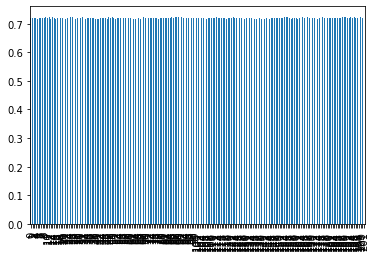

In [32]:
pd.Series(experiment.agent._UCB).plot.bar()

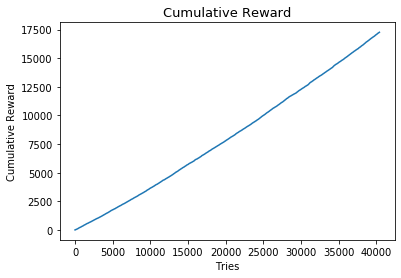

In [33]:
experiment.plot_cumulative_reward()

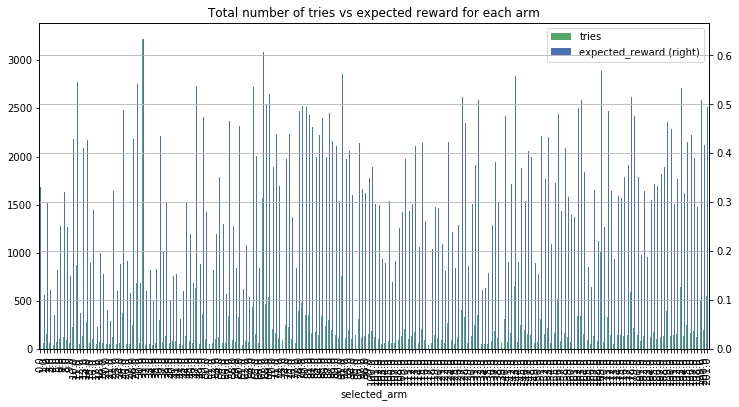

In [34]:
plot_tries_vs_expected_reward(agent.tries, expected_reward)

# Bayesian UCB

Instead of assessing the UCB roughly with Hoeffding’s Inequality, we use our knowledge of the Bernoulli distribution and it's conjugate prior, the Beta distribution, to assess the upper confindence bound

In [35]:
??BayesUCB

Init signature: BayesUCB(n_arms, c=2)
Source:        
class BayesUCB(Agent):
    """Assess UCB using knowledge of the Bernoulli distribution and it's conjugate prior, the Beta distribution."""
    def __init__(self, n_arms, c=2):
        """
        n_arms: int
            Number of arms
        c: float
            Amount of standard deviations considered for the UCB
        """
        super().__init__(n_arms)
        self.c = c # Amount of standard deviations considered for UCB
        self._params_a = np.ones(n_arms) # Params a of Beta
        self._params_b = np.ones(n_arms) # Params b of Beta
  
    def add_observation(self, arm, reward):
        """
        arm: int
            Arm chosen in the observation
        reward: bool
            Reward obtained in the observation
        """
        super().add_observation(arm, reward)
        self._params_a[arm] += reward
        self._params_b[arm] += 1 - reward
    
    def select_arm(self):
        # Start playing each arm once
  

In [36]:
agent = BayesUCB(n_arms=n_arms) # Define Agent
 
experiment = Experiment(agent, environment, T, 'BayesUCB') # Run Experiment

experiment_history.append(experiment) # Add experiment to history

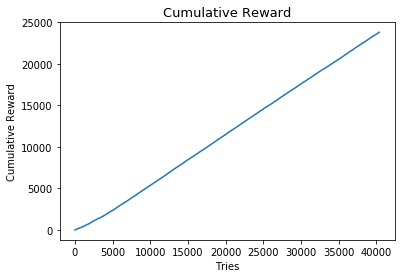

In [37]:
experiment.plot_cumulative_reward()

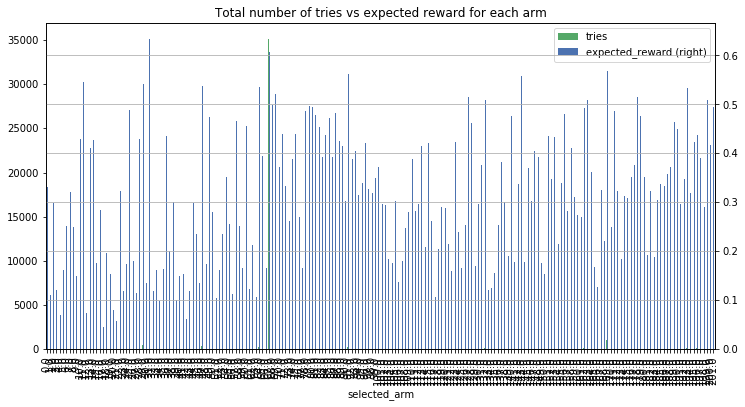

In [38]:
plot_tries_vs_expected_reward(agent.tries, expected_reward)

# Thompson Sampling

Every arm is supposed to be a Beta distribution with parameters `a` = successes, `b` = failures.

At each step we sample from the Beta distributions of all arms and chose the arm with the largest sample.

In [39]:
??ThompsonSampling

Init signature: ThompsonSampling(n_arms)
Source:        
class ThompsonSampling(Agent):
    """Every arm is supposed to be a Beta distribution with parameters `a` = successes, `b` = failures.

    At each step we sample from the Beta distributions of all arms and chose an arm with the largest sample."""
    def __init__(self, n_arms):
        """
        n_arms: int
            Number of arms
        """
        super().__init__(n_arms)
        self._params_a = np.ones(n_arms) # Params a of Beta
        self._params_b = np.ones(n_arms) # Params b of Beta
  
    def add_observation(self, arm, reward):
        """
        arm: int
            Arm chosen in the observation
        reward: bool
            Reward obtained in the observation
        """
        super().add_observation(arm, reward)
        self._params_a[arm] += reward
        self._params_b[arm] += 1 - reward
    
    def select_arm(self):
        # Start playing each arm once
        if self._total_tries < self.n_arms:
   

In [40]:
agent = ThompsonSampling(n_arms=n_arms) # Define Agent
 
experiment = Experiment(agent, environment, T, 'ThompsonSampling') # Run Experiment

experiment_history.append(experiment) # Add experiment to history

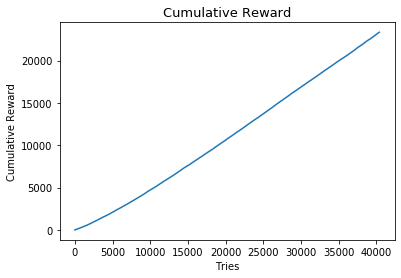

In [41]:
experiment.plot_cumulative_reward()

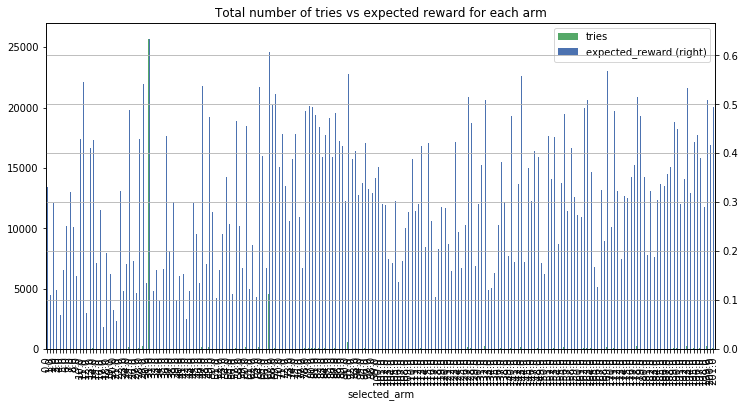

In [42]:
plot_tries_vs_expected_reward(agent.tries, expected_reward)

# Comparing the results of all different experiments

Text(0.5, 1.0, 'Cumulative Reward for different Bandits Algorithms')

/home/liamt/.pyenv/versions/3.7.6/envs/sc-analysis/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


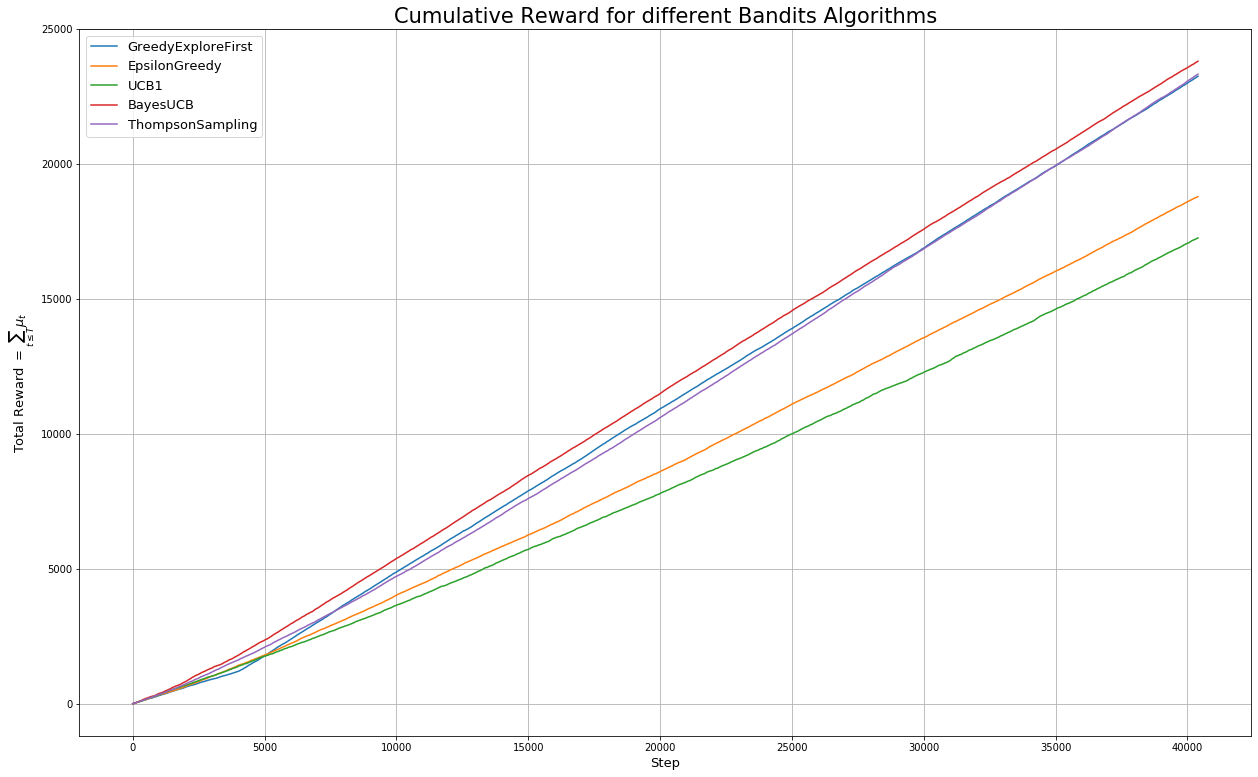

In [43]:
plt.figure(figsize=(21,13))
for i in range(len(experiment_history)):
    plt.plot(experiment_history[i].cumulative_reward_history, label=experiment_history[i].name)
plt.legend(fontsize=13)
plt.xlabel('Step', fontsize=13)
plt.ylabel('Total Reward $= \sum_{t \leq T} \mu_t$', fontsize=13)
plt.grid()
plt.title('Cumulative Reward for different Bandits Algorithms',fontsize=21)

In [44]:
print('Final Rewards:')
[(experiment_history[i].name, experiment_history[i].cumulative_reward_history[-1]) for i in range(len(experiment_history))]

Final Rewards:


[('GreedyExploreFirst', 23261),
 ('EpsilonGreedy', 18798),
 ('UCB1', 17268),
 ('BayesUCB', 23818),
 ('ThompsonSampling', 23338)]